In [1]:
import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np
import os
import time
import matplotlib.pyplot as plt

gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0:
    for gpu in gpu_list:
        tf.config.experimental.set_memory_growth(gpu, True) 

D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda\envs\tf-gpu-2.10.0-py-3.10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
texts = []
step = 101

for i in range(0, len(text), step):
    t = text[i: i+step]
    texts.append(t.strip())

context = np.array([t[:-1] for t in texts])
target = np.array([t[1:] for t in texts])

BUFFER_SIZE = len(texts)
BATCH_SIZE = 64
is_train = np.random.uniform(size=(BUFFER_SIZE,)) < 0.8
train_raw = tf.data.Dataset.from_tensor_slices((context[is_train],target[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_raw = tf.data.Dataset.from_tensor_slices((context[~is_train], target[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def lower_split_util(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    return tf.strings.unicode_split(text, 'UTF-8')

text_processor = tf.keras.layers.TextVectorization(standardize=lower_split_util, split=None)
text_processor.adapt(train_raw.map(lambda context,target:context))

def process_train_ds(context, target):
    context = text_processor(context)
    target = text_processor(target)
    return context, target

train_ds = train_raw.map(process_train_ds, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_train_ds, tf.data.AUTOTUNE)
for A,B in train_ds.take(1):
    print(A[:1])
    print(B[:1])
# for context_ex, target_ex in train_ds:
#     assert context_ex.shape[1] == target_ex.shape[1]
# print("success")

tf.Tensor(
[[ 3  2 19  3  9  3  2  4  9 15  3 18  2  7  3  2  8  7  5 15 13 14  2 24
   3  2 22  9  6 21 11  5 15  8 29 12 12 27 36 39 43 45 23 37 43 34 53  2
  34 51  2 52 34 36 54 26 12 41  7 17 18  2 16  6 14  6 16 18  2  8  5 18
   2 10  5  2 14  5 15 24  4 18  2  7  3  2 11  8 29 12 12 49 42 39 43 32
  37 37  2 34]], shape=(1, 100), dtype=int64)
tf.Tensor(
[[ 2 19  3  9  3  2  4  9 15  3 18  2  7  3  2  8  7  5 15 13 14  2 24  3
   2 22  9  6 21 11  5 15  8 29 12 12 27 36 39 43 45 23 37 43 34 53  2 34
  51  2 52 34 36 54 26 12 41  7 17 18  2 16  6 14  6 16 18  2  8  5 18  2
  10  5  2 14  5 15 24  4 18  2  7  3  2 11  8 29 12 12 49 42 39 43 32 37
  37  2 34 51]], shape=(1, 100), dtype=int64)


In [3]:
vocab_size = text_processor.vocabulary_size()
embedding_dim = 256
rnn_units = 1024

class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        if return_state:
            return x, states
        else:
            return x
model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

In [4]:
y_true = np.array([0, 1, 2])  
y_pred = np.array([[0.9, 0.05, 0.05],   
                  [0.1, 0.8, 0.1],
                  [0.2, 0.2, 0.6]])
y_pred_probability = y_pred[np.arange(len(y_true)), y_true]
loss = -np.log(y_pred_probability)
print(tf.reduce_mean(loss).numpy(), tf.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred).numpy())

0.2797765635793423 0.2797765635793423


In [5]:
predictions = np.array([0.1, 0.3, 0.6])
true_label = 2
predicted_probability = predictions[true_label]
loss = -np.log(predicted_probability)
print(loss, tf.losses.SparseCategoricalCrossentropy(from_logits=False)(true_label, predictions).numpy() )

0.5108256237659907 0.5108256237659906


In [6]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)   # 一开始近似等于 -np.log(1/5000)
optimizer = tf.optimizers.Adam()
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('./traning_checkpoints', "ckpt_{epoch}"), save_weights_only=True)
early = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[checkpoint_callback, early])  # 2.3G

Epoch 1/100
138/138 [==============================] - 6s 23ms/step - loss: 2.8639 - val_loss: 2.2649
Epoch 2/100
138/138 [==============================] - 2s 11ms/step - loss: 2.1018 - val_loss: 1.9535
Epoch 3/100
138/138 [==============================] - 2s 11ms/step - loss: 1.8318 - val_loss: 1.7405
Epoch 4/100
138/138 [==============================] - 2s 11ms/step - loss: 1.6540 - val_loss: 1.6017
Epoch 5/100
138/138 [==============================] - 2s 11ms/step - loss: 1.5361 - val_loss: 1.5159
Epoch 6/100
138/138 [==============================] - 2s 11ms/step - loss: 1.4534 - val_loss: 1.4636
Epoch 7/100
138/138 [==============================] - 2s 11ms/step - loss: 1.3916 - val_loss: 1.4252
Epoch 8/100
138/138 [==============================] - 2s 11ms/step - loss: 1.3403 - val_loss: 1.4039
Epoch 9/100
138/138 [==============================] - 2s 11ms/step - loss: 1.2954 - val_loss: 1.3881
Epoch 10/100
138/138 [==============================] - 2s 11ms/step - loss: 1.254

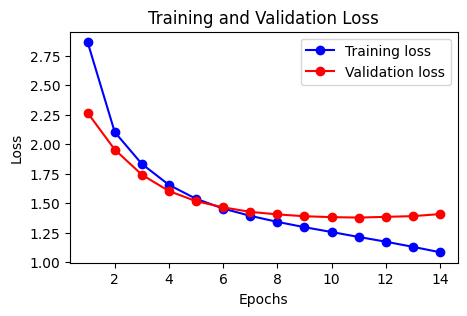

In [7]:
def plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot(history)

In [11]:
class OneStep(tf.keras.Model):
    def __init__(self, model, text_processor, temperature=1.0):
        super().__init__()
        self.text_processor = text_processor
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),  mask_token='', oov_token='[UNK]', )
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_processor.get_vocabulary(),  mask_token='', oov_token='[UNK]',invert=True)
        self.temperature = temperature
        self.model = model
        
        skip_ids = self.word_to_id(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(values = [-float('inf')] * len(skip_ids), indices=skip_ids, dense_shape=[len(self.word_to_id.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)
    
    @tf.function
    def generate_one_step(self, inputs, states=None):
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.word_to_id(input_chars).to_tensor()
        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)  # (1, None, 67)
        predicted_logits = predicted_logits[:, -1, :] / self.temperature + self.prediction_mask  # (1, 67)
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1) # (1, 1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)  # (1)
        predicted_chars = self.id_to_word(predicted_ids)
        return predicted_chars, states

one_step_model = OneStep(model, text_processor)
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]
for n in range(100):
    next_char, states = one_step_model.generate_one_step(inputs=next_char, states=states)
    result.append(next_char)
result = tf.strings.join(result)
end = time.time()
print(result,'\n' ,end-start)

tf.Tensor([b"ROMEO:\nIt is much touch'd his mother's house.\nCars you be not woo't against Cutilly and fire;\nAnd I, that "], shape=(1,), dtype=string) 
 0.6237337589263916


在自然语言处理和生成任务中，如使用GPT-3或GPT-4模型生成文本时，**temperature** 是一个重要的参数，它控制生成文本的随机性和多样性。

### 作用与原理

- **温度 (temperature)** 是用于调整模型生成的概率分布的参数。它在生成下一个词时影响选择词的概率。
- **公式**: 在技术上，temperature 调整 softmax 函数的输入。具体来说，如果`logits`表示模型预测的每个词的对数概率，temperature调整后的对数概率为`logits / temperature`。

### 温度的影响

1. **高温度** (>1.0)
   - 增加随机性。
   - 使模型更有可能选择低概率词汇。
   - 结果更有创意和多样性，但可能更不相关或不连贯。
   - 适用于需要创造力和非结构化输出的场景，如故事生成、诗歌写作。

2. **低温度** (<1.0)
   - 减少随机性。
   - 模型更倾向于选择高概率词汇。
   - 结果更确定、连贯，但可能缺乏多样性和新意。
   - 适用于需要确定性和结构化的输出场景，如技术文档生成、简洁回答。

3. **温度为1.0**
   - 模型输出与概率分布直接相关。
   - 不调整生成概率的随机性。

### 示例
假设我们用模型生成一个句子，使用不同的 temperature 会导致不同的结果。

- **Temperature = 0.7**: 
  - "The cat sat on the mat."
  - 更连贯，选择更确定的词。

- **Temperature = 1.0**:
  - "The cat perched on the sunny mat."
  - 具有适度的随机性和创造性。

- **Temperature = 1.5**:
  - "A curious feline leaped onto a vibrant rug."
  - 更具创意和变化，但可能不太连贯。
 